# Table of Contents
 <p><div class="lev1"><a href="#Data-import-and-pre-processing"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data import and pre-processing</a></div><div class="lev2"><a href="#Spherical-coordinates?"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Spherical coordinates?</a></div><div class="lev2"><a href="#reading-Dates"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>reading Dates</a></div><div class="lev1"><a href="#GP-model-for-time-series"><span class="toc-item-num">2&nbsp;&nbsp;</span>GP model for time series</a></div><div class="lev2"><a href="#Kernel-Specification"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Kernel Specification</a></div><div class="lev2"><a href="#Fitting-model"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Fitting model</a></div><div class="lev2"><a href="#Optimize-parameters"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Optimize parameters</a></div><div class="lev2"><a href="#Redundancy-of-multiplicative-variance-parameters"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Redundancy of multiplicative variance parameters</a></div><div class="lev2"><a href="#Observations-and-thoughts"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Observations and thoughts</a></div><div class="lev1"><a href="#Sparse-GP"><span class="toc-item-num">3&nbsp;&nbsp;</span>Sparse GP</a></div><div class="lev2"><a href="#Optimize-parameters-using-sparse-GP"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Optimize parameters using sparse GP</a></div>

$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\var}{var}
    \DeclareMathOperator{\cov}{cov}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \DeclareMathOperator{\GP}{\mathcal{GP}}
    \DeclareMathOperator{\l}{\mathscr{l}}
$$

In this notebook, we'll focus on building up a complete Gaussian Process model for the hourly temperature records.

In [86]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import matplotlib
import math
import datetime
import GPy
import matplotlib.pyplot as plt
plt.rc("figure", autolayout=True)
from mpl_toolkits.basemap import Basemap
plt.rcParams['figure.figsize'] = (8.0, 6.0)
from pandas.tools.plotting import autocorrelation_plot

# Data import and pre-processing

In [2]:
isdList=pd.read_csv("isdList.csv")
isdList.head()

,USAF,WBAN,NAME,CTRY,STATE,ICAO,LAT,LON,ELEV,BEGIN,END
0,10010,99999,JAN MAYEN(NOR-NAVY),NO,NaN,ENJA,70.933,-8.667,9.0,1931,2015
1,10060,99999,EDGEOYA,NO,NaN,NaN,78.250,22.817,14.0,1973,2015
2,10070,99999,NY-ALESUND,SV,NaN,NaN,78.917,11.933,7.7,1973,2015
3,10080,99999,LONGYEAR,SV,NaN,ENSB,78.246,15.466,26.8,1975,2015
4,10090,99999,KARL XII OYA,SV,NaN,NaN,80.650,25.000,5.0,1955,2015


## Spherical coordinates?

The circle of latitude $\theta$ has radius $R_\bigoplus \abs{\cos \theta}$. So if we multiply longitudes by that radius, we get something roughly consistent, except across the International Date Line. Diagonal distances also won't be quite right, but only for large distances, which we don't care much about anyway.

In [3]:
isdList["LONdist"] = np.abs(np.cos(np.radians(isdList["LAT"])))*isdList["LON"]

Focus on stations in Iowa:

In [4]:
isdSubset=isdList[isdList["USAF"].isin((725450,725460,725480,725485))]
isdSubset

,USAF,WBAN,NAME,CTRY,STATE,ICAO,LAT,LON,ELEV,BEGIN,END,LONdist
4062,725450,14990,THE EASTERN IOWA AIRPORT,US,IA,KCID,41.883,-91.717,264.6,1973,2015,-68.284193
4063,725460,14933,DES MOINES INTERNATIONAL AIRPORT,US,IA,KDSM,41.534,-93.653,291.7,1973,2015,-70.105113
4066,725480,94910,WATERLOO MUNICIPAL AIRPORT,US,IA,KALO,42.554,-92.401,264.6,1960,2015,-68.066299
4067,725485,14940,MASON CITY MUNICIPAL ARPT,US,IA,KMCW,43.154,-93.327,373.4,1973,2015,-68.083725


## reading Dates

In [5]:
station_filenames = ["%d.%d.processed.2015.2015.csv" % (r["USAF"],r["WBAN"]) for i,r in isdSubset.iterrows()]
def add_dates(df):
    df_dates = [datetime.datetime(*map(int, r[1][["year","month","day","hour","min","seconds"]])) for r in df.iterrows()]
#     df["datetime"] = df_dates
    temp_series = pd.Series(df["temp"].values, index=pd.DatetimeIndex(df_dates))
#     df.set_index(keys=["datetime"], inplace=True)
#     return df["temp"]
    return temp_series
    
hourly_ls = [pd.read_csv("data2015/"+fn, names=["year", "month", "day", "hour", "min", "seconds","temp"]) 
    for fn in station_filenames]
hourly_ls = list(map(add_dates, hourly_ls))

In [104]:
station_filenames

['725450.14990.processed.2015.2015.csv',
 '725460.14933.processed.2015.2015.csv',
 '725480.94910.processed.2015.2015.csv',
 '725485.14940.processed.2015.2015.csv']

''

 /Users/imolk/bin/venv_python3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


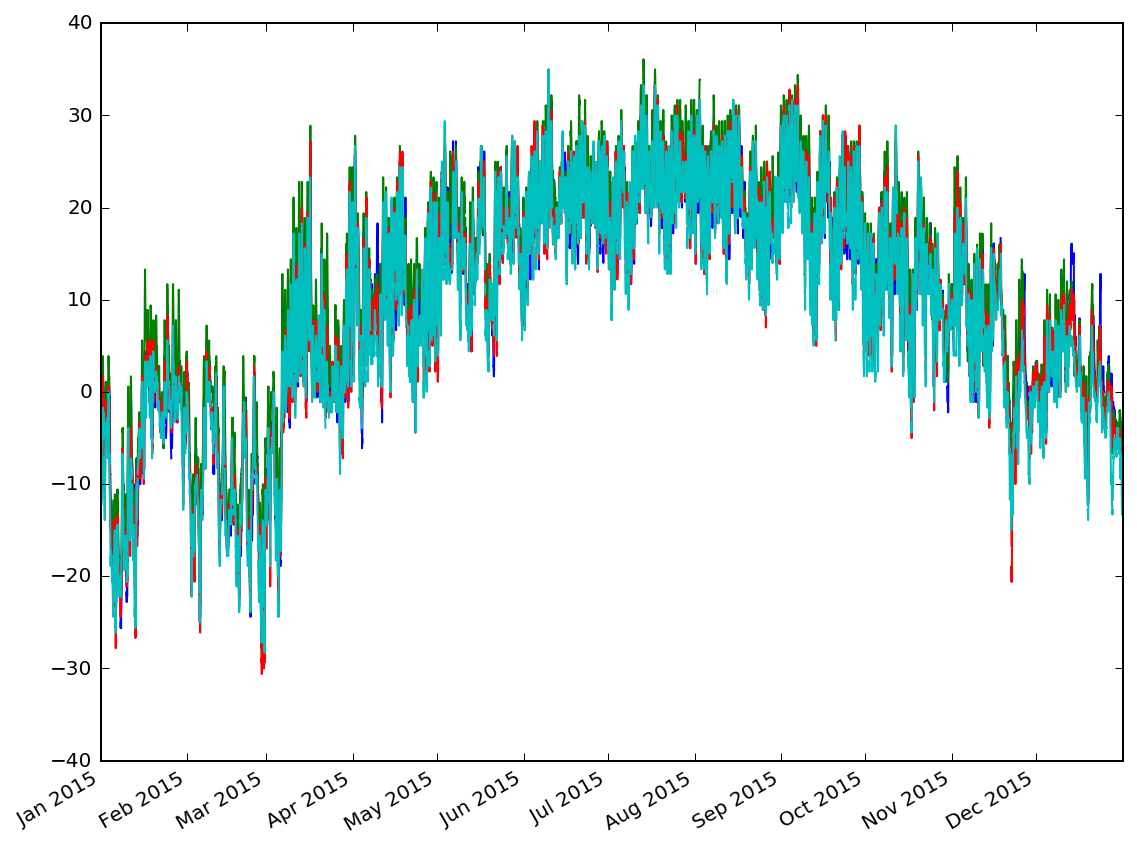

In [6]:
for hourly in hourly_ls:
    plt.plot(hourly)
plt.gcf().autofmt_xdate()
;

In [7]:
first = hourly_ls[0].dropna(inplace=False)

In [8]:
first.size

11118

# GP model for time series

## Kernel Specification

The kernel specification is inspired by the analysis of the Mauna Loa Atmospheric Carbon Dioxide in Rasmussen&Williams section 5.4.3.

\begin{align}
    k_1(t,t') &= \theta_1^2 \del{1 + \frac{\del{t-t'}^2}{2\theta_2\theta_3^2} }^{-\theta_2} & ~\text{(decay of the diurnal component)}\\
    k_2(t,t') &= \theta_4^2 \exp\del{\frac{ 2\sin\del{\pi\del{t - t'}\big/\del{\mathrm{24 hrs}}}} {\theta_5^2}} & ~\text{(diurnal cycle)}\\
    k_3(t,t') &= \theta_6^2 \exp\del{\frac{ 2\sin\del{\pi\del{t - t'}\big/\del{\mathrm{365 days}}}} {\theta_7^2}} & ~\text{(seasonal cycle)}\\
    k_4(t,t') &= \theta_8^2 \del{1 + \frac{\del{t-t'}^2}{2\theta_9\theta_{10}^2} }^{-\theta_9} & ~\text{(noise component)}\\
\end{align}

In [107]:
ns_per_day = 1e9 * 3600 * 24
# diurnal cycle
k1 = GPy.kern.RBF(input_dim=1, active_dims=[0], variance=1.0, lengthscale=60.0)
k2 = GPy.kern.StdPeriodic(input_dim=1, active_dims=[0], variance=40.0, period=1.0, lengthscale=0.6)
# seasonal cycle
k3 = GPy.kern.StdPeriodic(input_dim=1, active_dims=[0], variance=10.0, period=365.0, lengthscale=10.0)
# noise
k4 = GPy.kern.RBF(input_dim=1, active_dims=[0], variance=13.0, lengthscale=0.3)
# fix the period of periodic kernels:
k1.variance.fix()
k2.period.fix()
k3.period.fix()
# sum of kernels
kernel = k1*k2+k3+k4

## Fitting model

In [109]:
t=first.index.values.astype(int)/ns_per_day
t=t-t.min()
T=20000
model=GPy.models.GPRegression(t[:T,None],first.values[:T,None],kernel)

 /Users/imolk/bin/venv_python3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


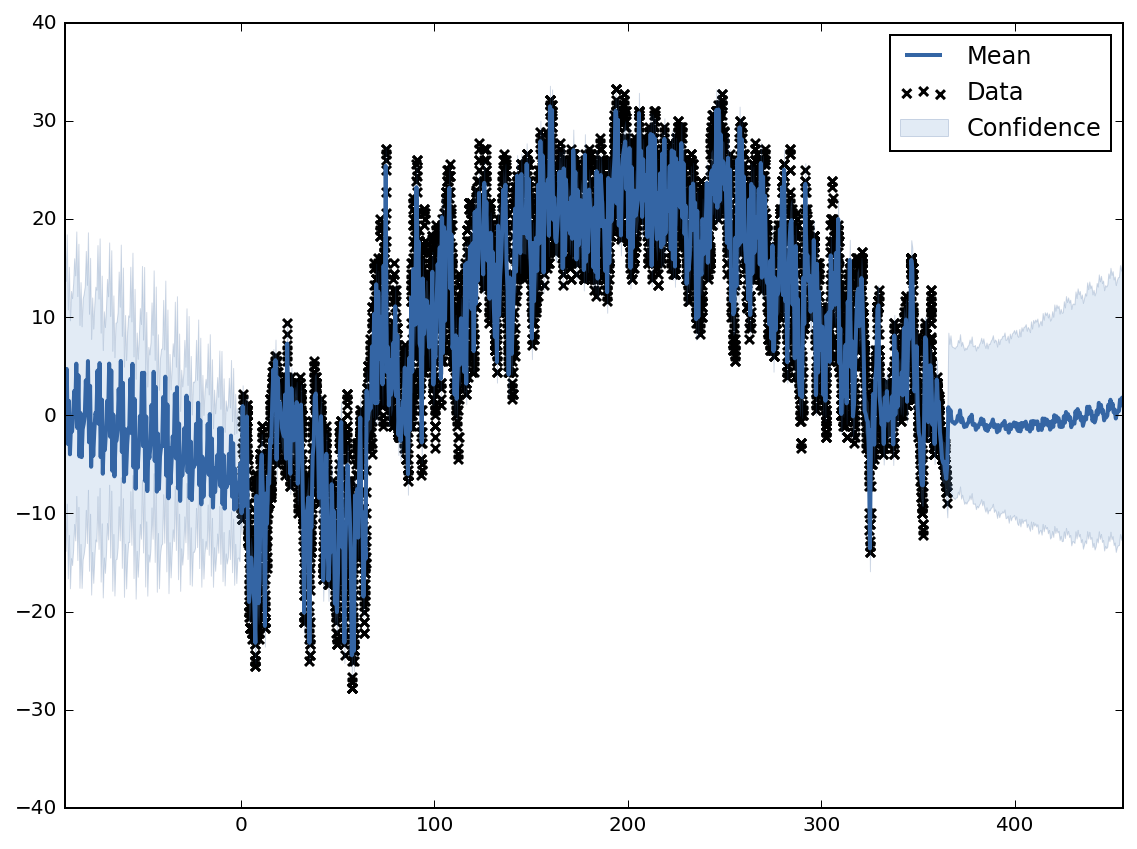

In [110]:
model.plot(resolution=1000)

 /Users/imolk/bin/venv_python3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


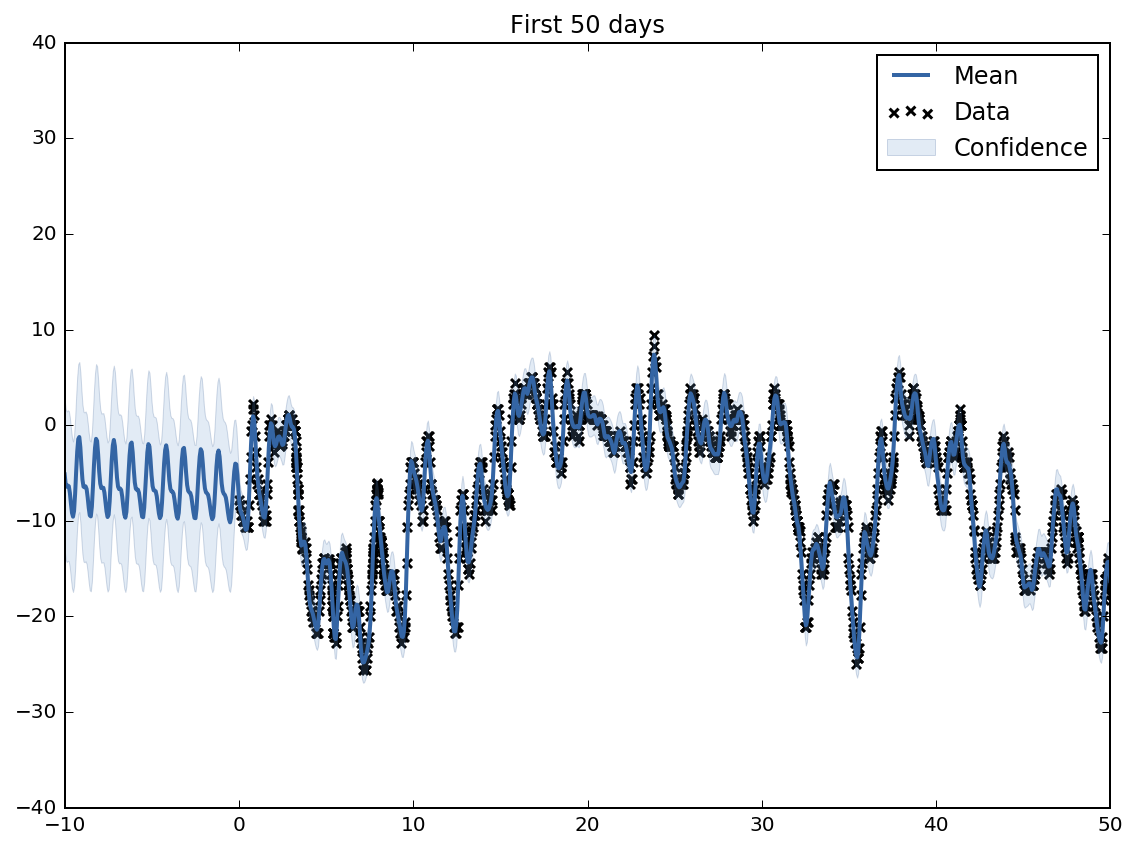

In [111]:
model.plot(resolution=1000, plot_limits=(-10,50)) # first 50 days
plt.title("First 50 days")

 /Users/imolk/bin/venv_python3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


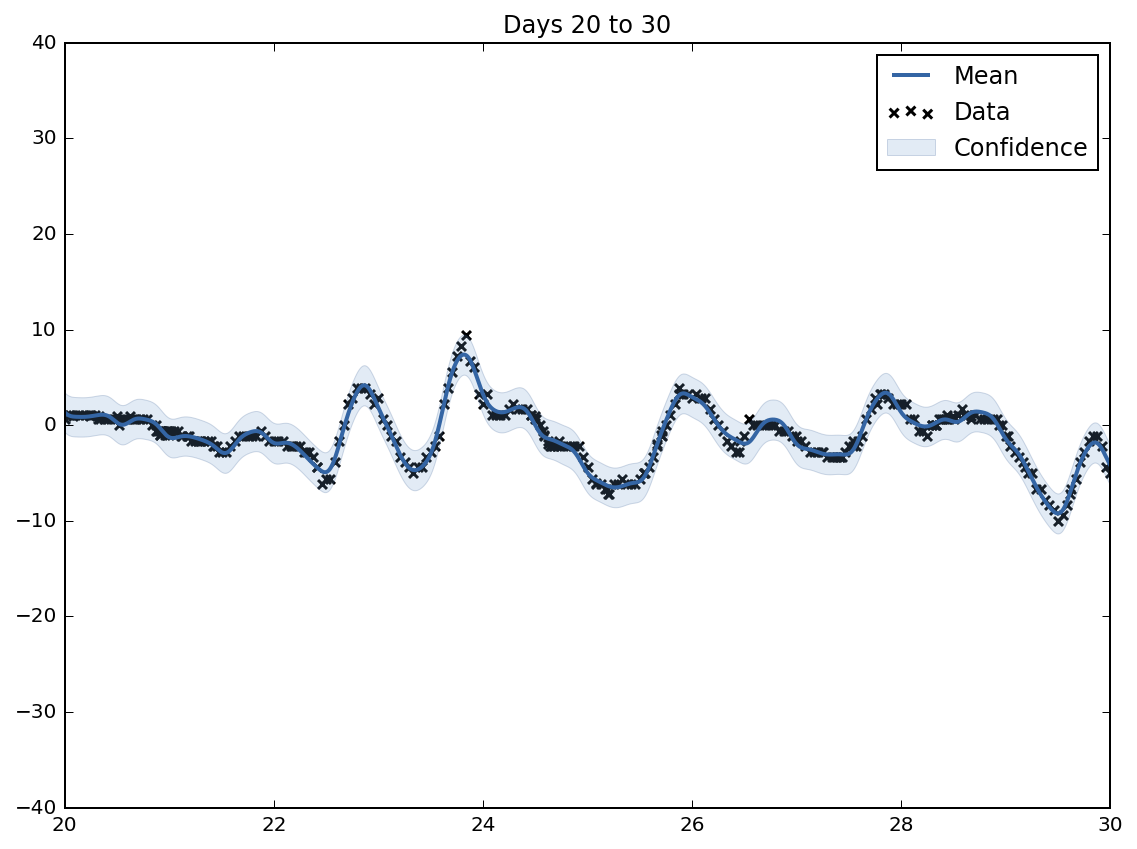

In [112]:
model.plot(resolution=1000, plot_limits=(20,30))
plt.title("Days 20 to 30")

## Optimize parameters

In [14]:
model.optimize(messages=True)

TypeError: non-empty format string passed to object.__format__

 /Users/imolk/bin/venv_python3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


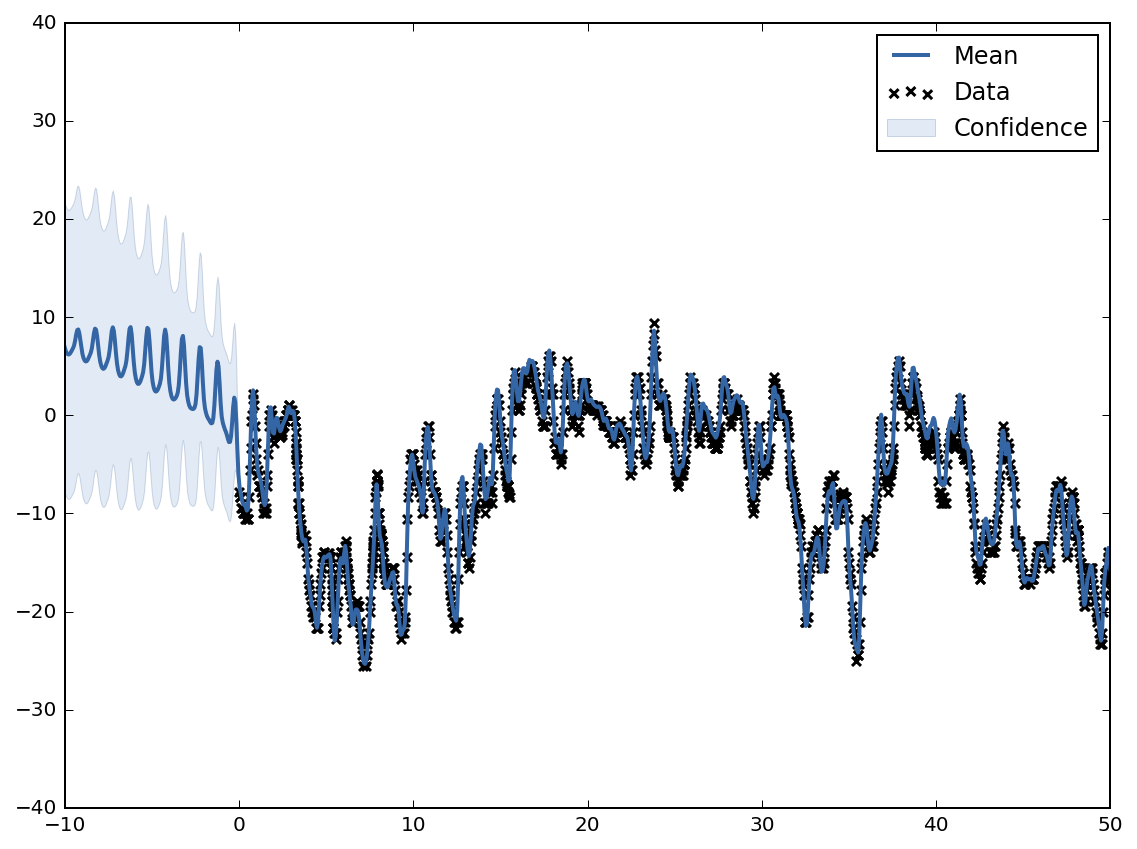

In [19]:
model.plot(resolution=1000, plot_limits=(-10,50)) # first 50 days

## Redundancy of multiplicative variance parameters

Note that $\theta_1$ and $\theta_4$ are not identifiable. We can see that the kernel function remains unchanged if we multiply $\theta_1$ by 10 and divide $\theta_4$ by 10.

In [78]:
kcopy=model.kern.copy()
kcopy.parts[0].parts[0].variance *= 10
kcopy.parts[0].parts[1].variance /= 10
kcopy.parts[0]

mul.,value,constraints,priors
std_periodic.variance,100.433600596,+ve,
std_periodic.period,1.0,+ve fixed,
std_periodic.lengthscale,0.619924736716,+ve,
rbf.variance,0.469192339623,+ve,
rbf.lengthscale,5.59523464142,+ve,


 /Users/imolk/bin/venv_python3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


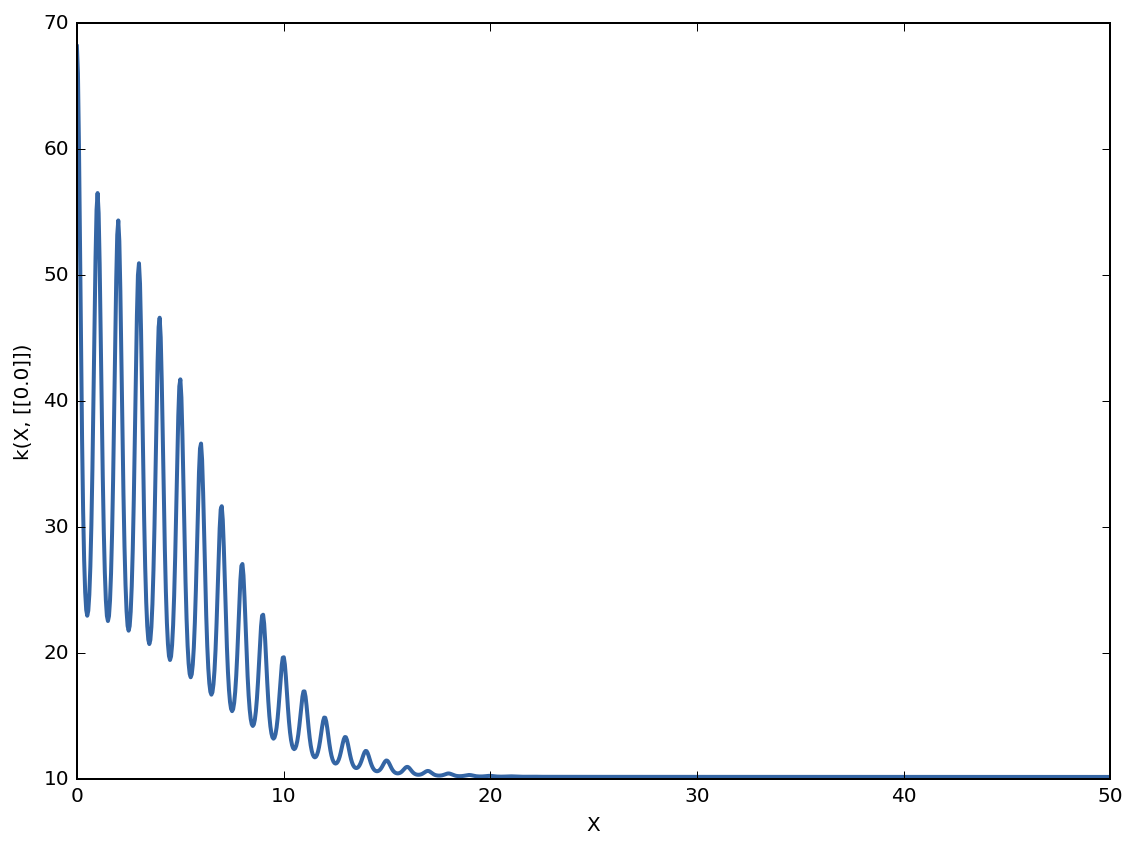

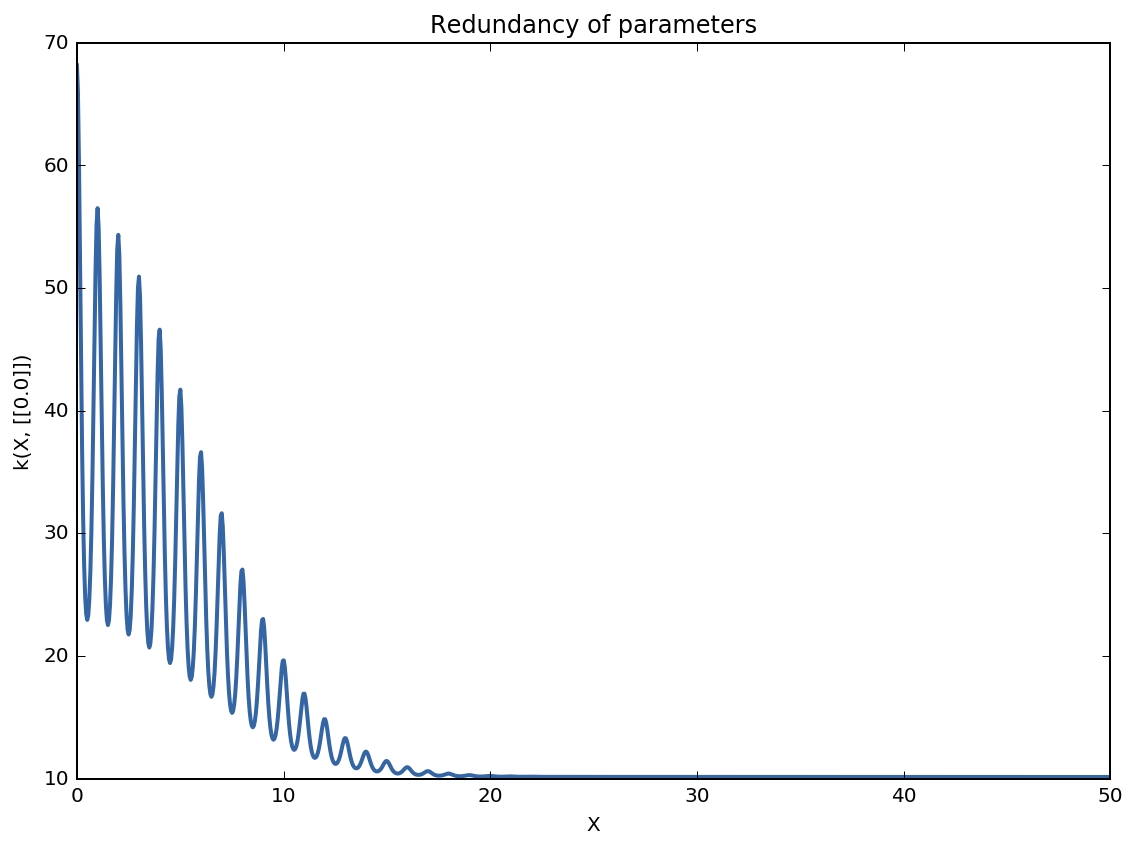

In [81]:
model.kern.plot_covariance(x=0, plot_limits=(0,50), resolution=1000)
kcopy.plot_covariance(x=0, plot_limits=(0,50), resolution=1000)
plt.title("Redundancy of parameters")

## Observations and thoughts
* It's a good thing that the Gaussian noise variance is low (0.22), but I think it maybe should be lower still. Is it reasonable to think that thermometers used in weather stations are off by $\sqrt{0.22}\approx0.5$ degrees? Actually... maybe yes if the measurements are rounded to the nearest degree.
* The confidence region around the posterior mean seem too wide. They seem to be 1 or 2 degrees wide. It really seems like we know the temperature near that weather station more precisely than that!
    * Does the confidence region include the gaussian noise variance?
* The diurnal cycle decays pretty rapidly ($l_t$ of 6 days). Is it reasonable to think that the diurnal cycle changes from one week to the next? How different is tomorrow from next Monday on average? It seems like there should be a component of the diurnal cycle that is much more stable than that. That being said, for our purposes, I don't think this will affect the imputations that much.

 /Users/imolk/bin/venv_python3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


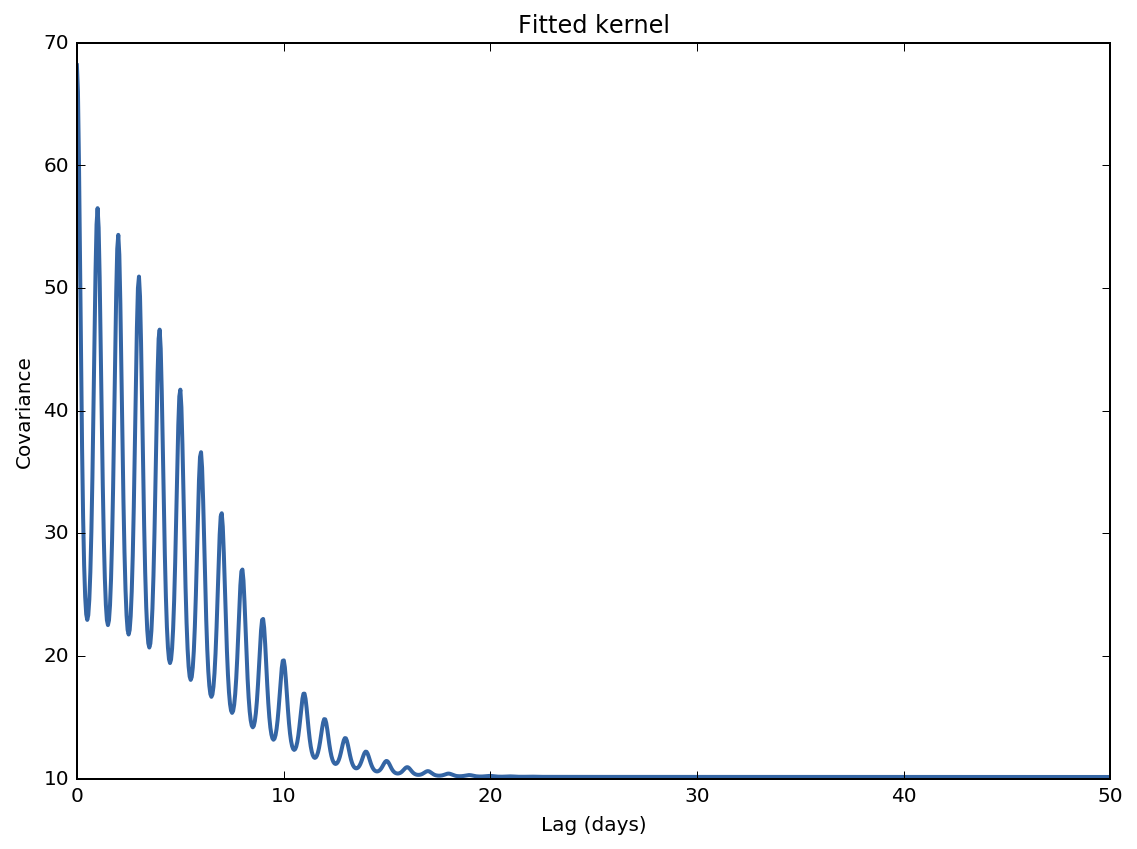

In [100]:
model.kern.plot_covariance(x=0, plot_limits=(0,50), resolution=1000)
plt.title("Fitted kernel")
plt.ylabel("Covariance")
plt.xlabel("Lag (days)")

**Problem**: This doesn't match the empirical ACF (below) well at all. The diurnal cycle shouldn't be so large and shouldn't be decaying so quickly.

In [101]:
np.var(first.dropna().resample('1H').mean().dropna().values)

144.71245081987422

 /Users/imolk/bin/venv_python3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


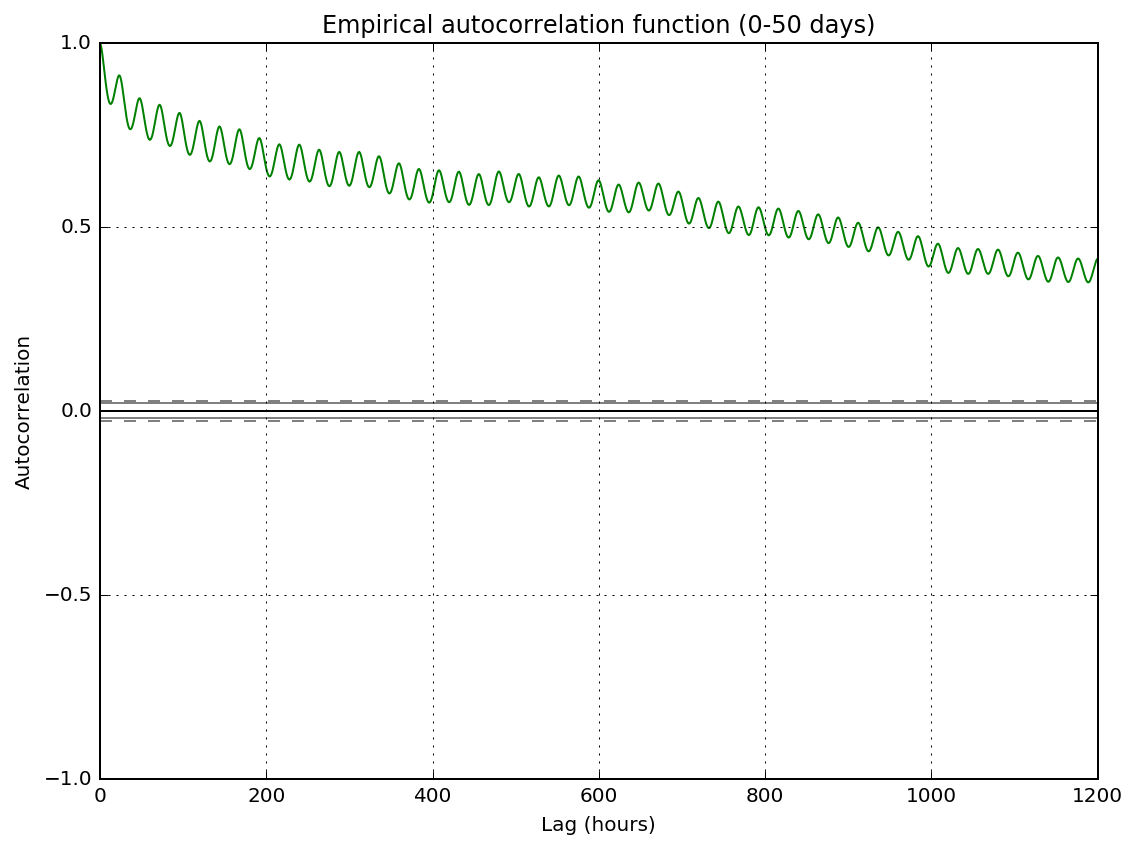

In [99]:
autocorrelation_plot(first.dropna().resample('1H').mean().dropna().values, color="green")
plt.xlim(0,24*50)
plt.title("Empirical autocorrelation function (0-50 days)")
plt.xlabel("Lag (hours)")

# Sparse GP

In [113]:
sparse_model = GPy.models.SparseGPRegression(t[:T,None],first.values[:T,None],model.kern, 
    Z=np.linspace(t[:T].min(), t[:T].max(), 1000)[:,None])   

 /Users/imolk/bin/venv_python3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


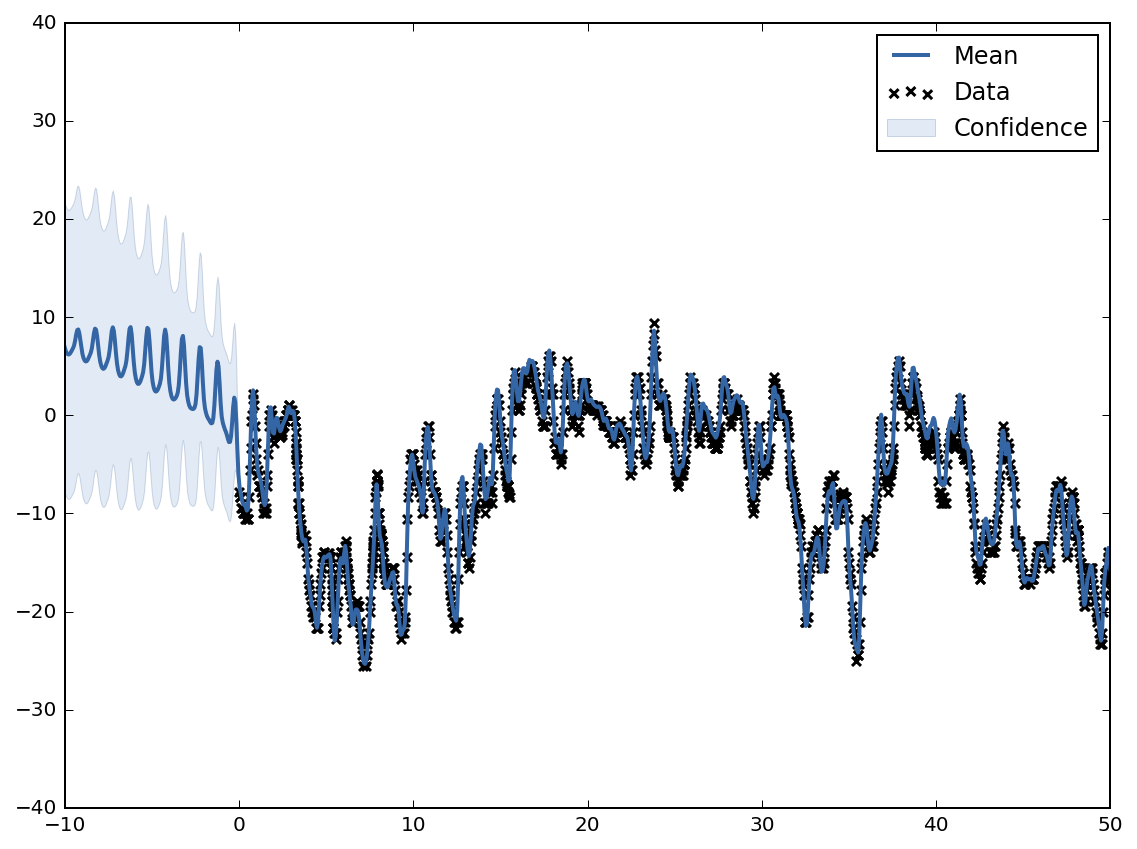

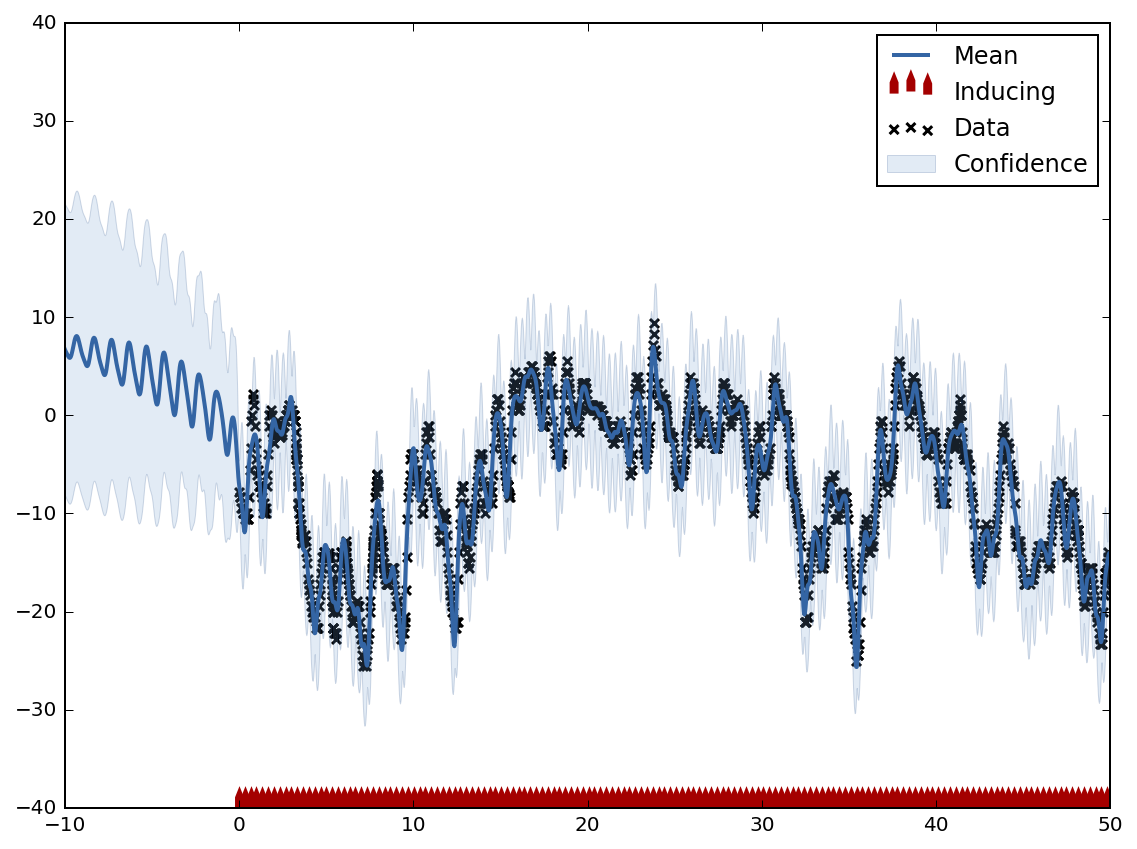

In [83]:
model.plot(resolution=1000, plot_limits=(-10,50)) # first 50 days
sparse_model.plot(resolution=2000, plot_limits=(-10,50))

In [84]:
sparse_model2 = GPy.models.SparseGPRegression(t[:T,None],first.values[:T,None],model.kern, 
    Z=(np.random.rand(1000)*(t.max()-t.min())+t.min())[:,None])

 /Users/imolk/bin/venv_python3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


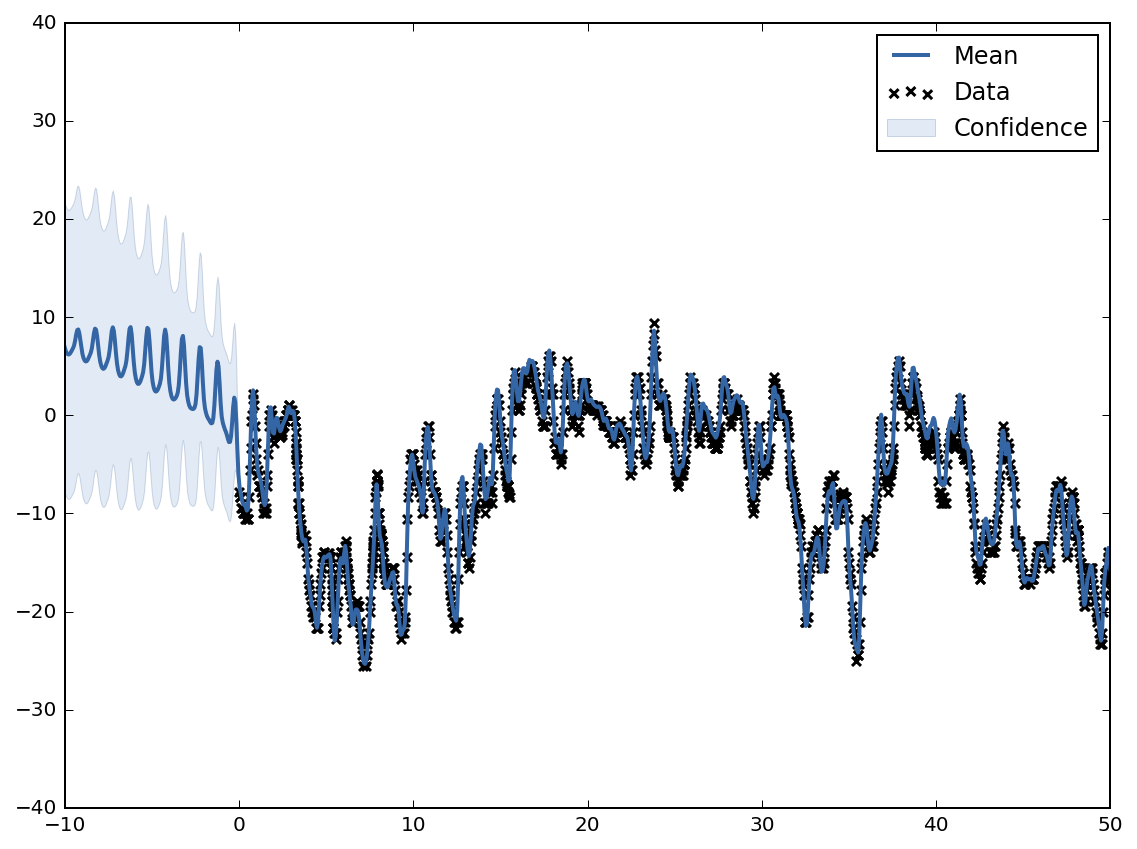

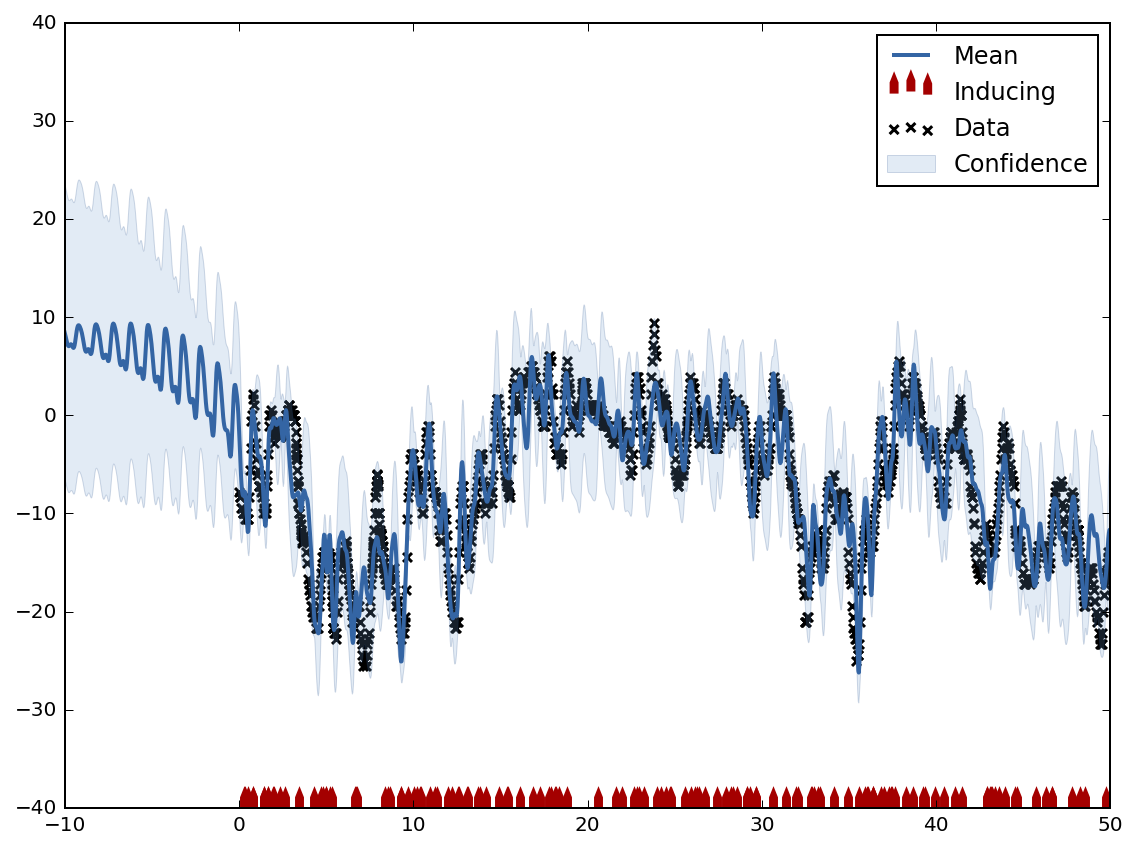

In [85]:
model.plot(resolution=1000, plot_limits=(-10,50)) # first 50 days
sparse_model2.plot(resolution=2000, plot_limits=(-10,50))

## Optimize parameters using sparse GP

In [117]:
sparse_model.inducing_inputs.fix()
sparse_model.optimize(optimizer="lbfgs", messages=True)

In [124]:
sparse_model.kern

sum.,value,constraints,priors
mul.rbf.variance,1.0,+ve fixed,
mul.rbf.lengthscale,450.198831552,+ve,
mul.std_periodic.variance,1229.89809893,+ve,
mul.std_periodic.period,1.0,+ve fixed,
mul.std_periodic.lengthscale,3.7481847693,+ve,
std_periodic.variance,509.137335713,+ve,
std_periodic.period,365.0,+ve fixed,
std_periodic.lengthscale,0.0583217748845,+ve,
rbf.variance,18.1299127977,+ve,
rbf.lengthscale,0.388849665924,+ve,


 /Users/imolk/bin/venv_python3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


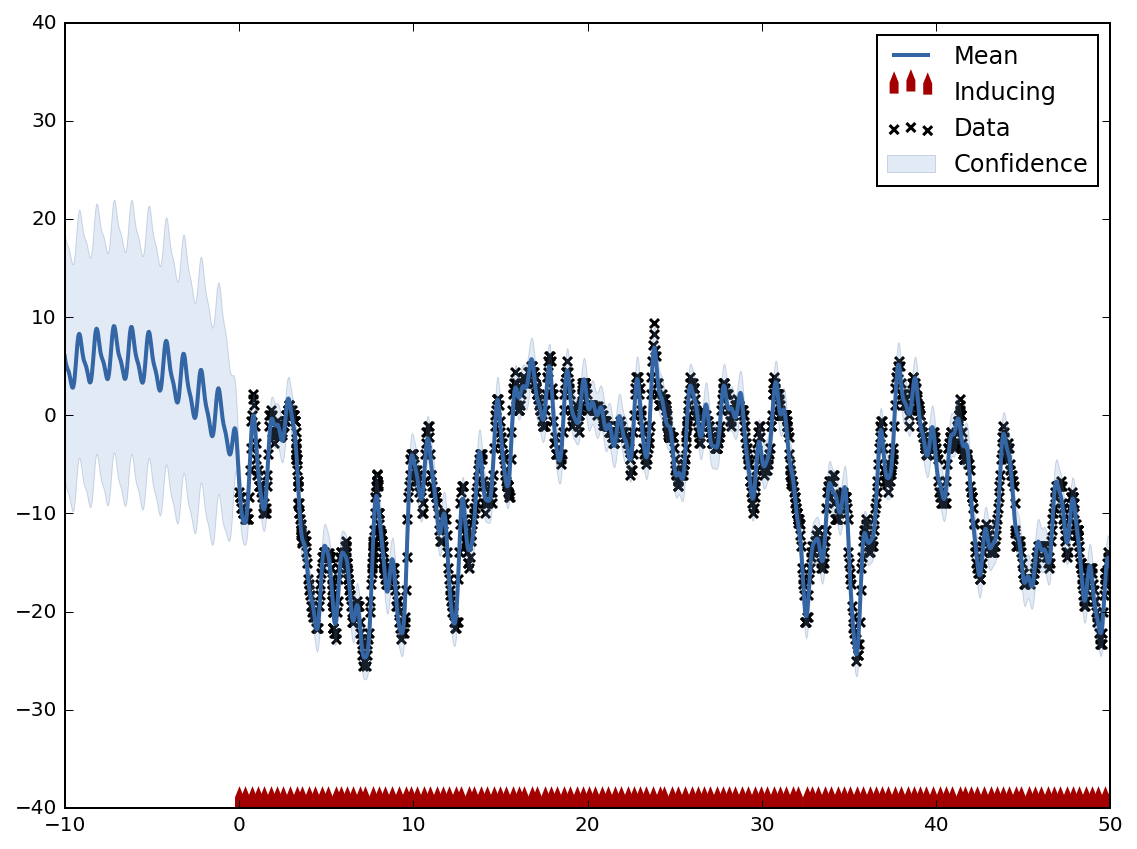

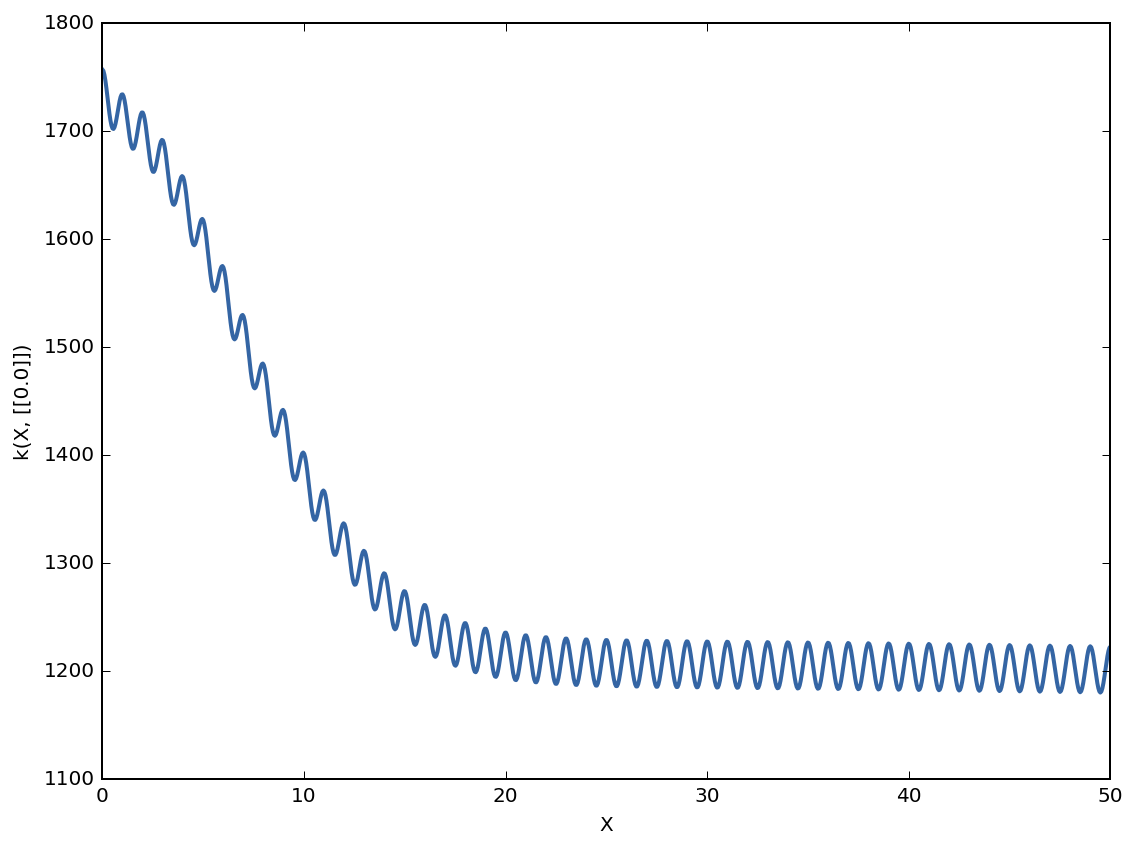

In [128]:
sparse_model.plot(resolution=2000, plot_limits=(-10,50))
sparse_model.kern.plot_covariance(x=0, plot_limits=(0,50), resolution=1000)

 /Users/imolk/bin/venv_python3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


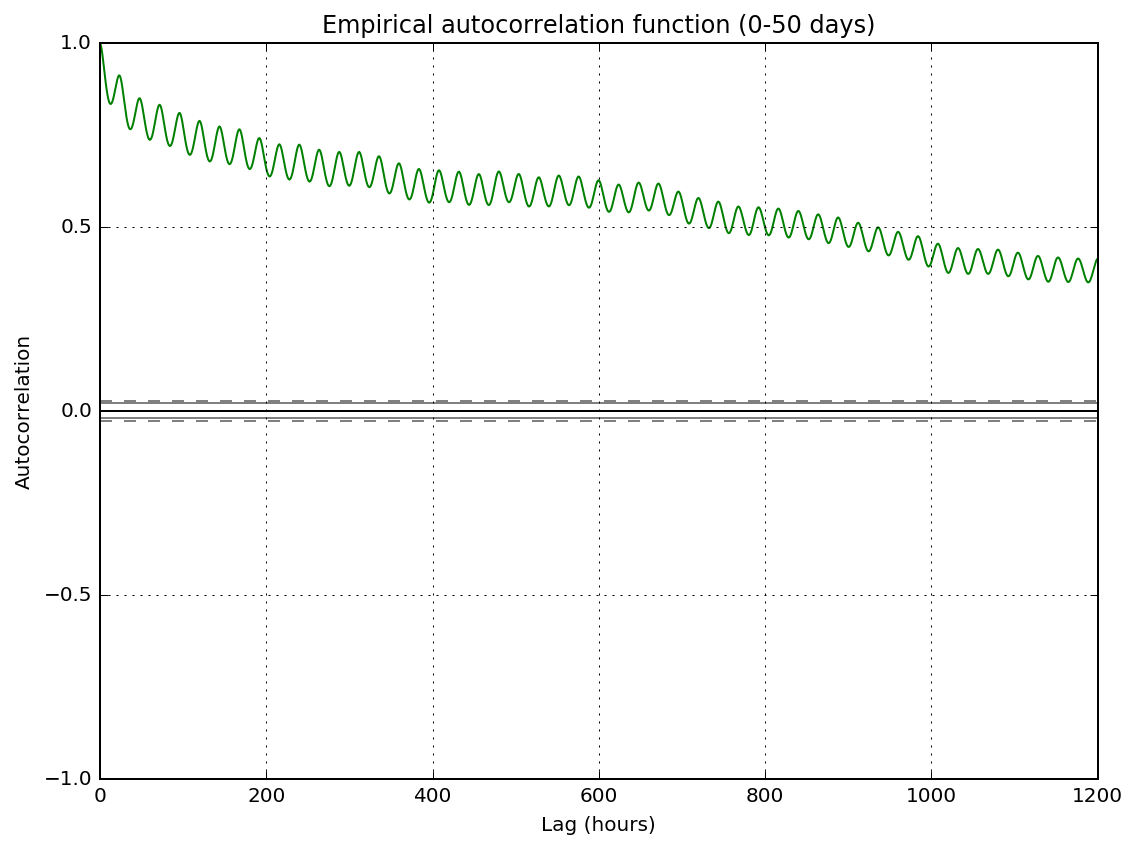

In [123]:
autocorrelation_plot(first.dropna().resample('1H').mean().dropna().values, color="green")
plt.xlim(0,24*50)
plt.title("Empirical autocorrelation function (0-50 days)")
plt.xlabel("Lag (hours)")